# Using Predictive Analytics to Predict Delays in Maritime Container Shipping

In [1]:
%matplotlib inline

**Import Libraries**

In [2]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
#https://github.com/pandas-dev/pandas/issues/8509
warnings.filterwarnings('ignore', 'numpy not_equal will not check object identity in the future')

#http://pythondata.com/dask-large-csv-python/
#import dask.dataframe as dd
 
#from collections import Counter
#from patsy import dmatrices
#import statsmodels.api as sm

#https://www.dataquest.io/blog/pandas-big-data/

In [3]:
#Open the dataframe
df = pd.read_pickle('D:/CUNY Files/capstone/code files/2014_data_LA_SH_V2.pkl')

** Get stats by vessel by month **

** Get voyage stats by month, month will be a proxy for vessel voyage **
- Given the length of vessel voyages between China and California we would not expect to see the same vessel arrive more than once a month, with the possible exception of a vessel that arrives at the beginning of a month and then returns at the end of the month.

In [4]:
#get the unique counts
voyage_stats_all = df.groupby(['vessel_name','month_act']
          )['identifier','record_status_indicator','foreign_port_of_lading','port_of_unlading',
            'trade_update_date','run_date','estimated_arrival_date','actual_arrival_date',
            'container_number','consignee_name','shipper_party_name'].nunique()

#flatten the index to make it easier to work with
voyage_stats_all.reset_index(col_level=1,inplace = True)

In [5]:
voyage_stats_all.shape

(1181, 13)

In [6]:
#view voyage stats in descending order of the number of actual arrival dates per vessel per month
voyage_stats_all.sort_values('actual_arrival_date',ascending = False).head(10)

,vessel_name,month_act,identifier,record_status_indicator,foreign_port_of_lading,port_of_unlading,trade_update_date,run_date,estimated_arrival_date,actual_arrival_date,container_number,consignee_name,shipper_party_name
998,OOCL KUALA LUMPUR,11,1099,2,1,2,38,22,17,14,976,456,515
555,HANJIN LONG BEACH,10,2382,2,1,2,32,19,18,11,1460,928,1010
991,OOCL ITALY,11,418,2,1,2,17,20,12,11,379,206,225
148,BANGKOK BRIDGE,8,144,2,1,2,18,8,10,10,158,112,124
414,CSCL WINTER,12,377,2,1,2,21,8,19,9,414,245,257
398,CSCL SPRING,12,820,2,1,1,33,10,14,8,1036,464,472
123,BAI CHAY BRIDGE,10,112,1,1,2,13,7,9,8,99,88,88
557,HANJIN LONG BEACH,12,886,2,1,2,27,10,18,8,880,462,493
421,CSCL YELLOW SEA,12,927,2,1,2,32,12,16,7,1106,526,515
300,COSCO EUROPE,10,1869,2,1,2,35,27,20,7,1033,710,744


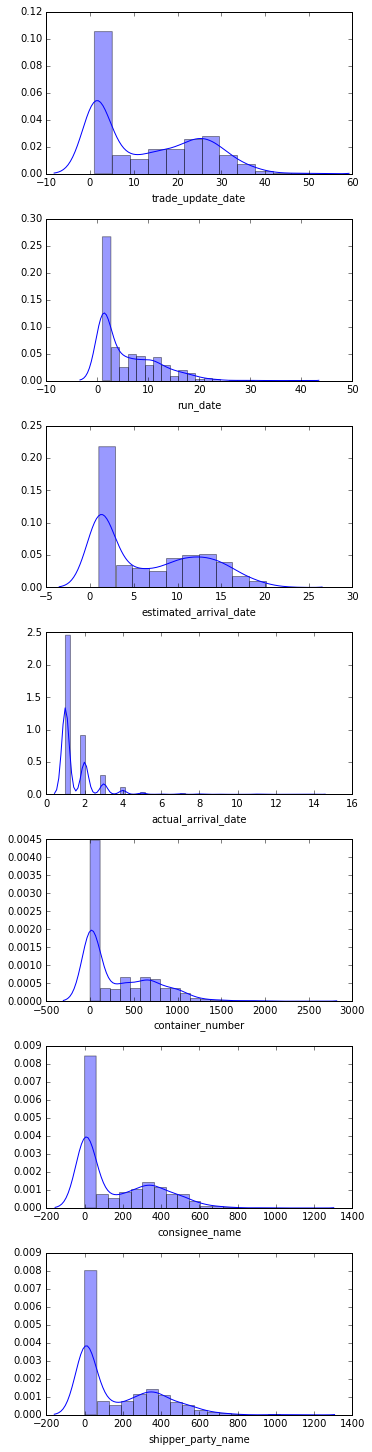

In [7]:
#view all distributions
n = 0
fig, axs = plt.subplots(nrows =7,figsize=(5,20))
for i,x in enumerate(list(voyage_stats_all)[6:]): 
    sns.distplot(voyage_stats_all[x], ax=axs[i])
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)

** View distributions of number of estimated and actual arrival date by vessel for each month **

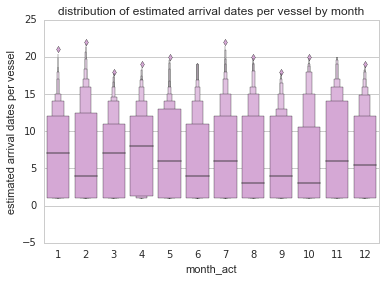

In [8]:
#view the distribution by month of estimated arrival dates
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="estimated_arrival_date", data=voyage_stats_all, color = 'plum')
ax.set_ylabel('estimated arrival dates per vessel')
ax.set_title('distribution of estimated arrival dates per vessel by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

[(0, 60)]

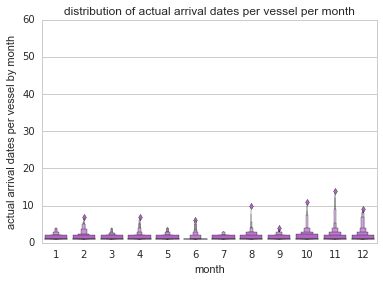

In [9]:
#view the distribution by month of actual arrival dates
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="actual_arrival_date", data=voyage_stats_all, color = 'mediumorchid')
ax.set_xlabel('month')
ax.set_ylabel('actual arrival dates per vessel by month')
ax.set_title('distribution of actual arrival dates per vessel per month')
ax.set(ylim=(0, 60))
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

** Compute the correlation between the number of arrival dates per ship and the number of containers per ship **

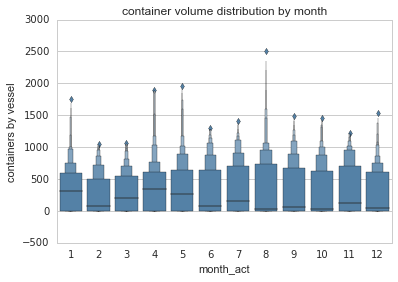

In [10]:
#view the distribution of containers per ship by month
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="container_number", data=voyage_stats_all, color = 'steelblue')
ax.set_ylabel('containers by vessel')
ax.set_title('container volume distribution by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

In [11]:
#average actual arrival dates per vessel
print voyage_stats_all.actual_arrival_date.mean()

#arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 2]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 2]) / (len(voyage_stats_all) * 1.0)

#arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 5]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 5]) / (len(voyage_stats_all) * 1.0)

1.59864521592
148 1181
0.125317527519
14 1181
0.0118543607113


In [12]:
#average estimated arrival dates per vessel
print voyage_stats_all.estimated_arrival_date.mean()

#estimated arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 5]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 5]) / (len(voyage_stats_all) * 1.0)

#estimated arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 10]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 10]) / (len(voyage_stats_all) * 1.0)

6.83488569009
584 1181
0.49449618967
383 1181
0.324301439458


In [13]:
#Correlation between the number of actual_arrival_dates and number of containers per ship per month
voyage_stats_all['actual_arrival_date'].corr(voyage_stats_all['container_number'])

0.38655931309345848

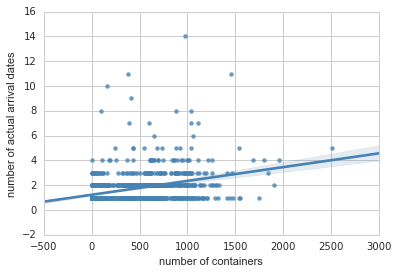

In [14]:
#show the relationship between volume and the number of actual arrival dates with a scatter plot
ax = sns.regplot(x="container_number", y="actual_arrival_date", data=voyage_stats_all, color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('number of containers')
ax.set_ylabel('number of actual arrival dates')

In [15]:
#Correlation between the number of estimated_arrival_dates and number of containers per ship per month
voyage_stats_all['estimated_arrival_date'].corr(voyage_stats_all['container_number'])

0.88789282764940547

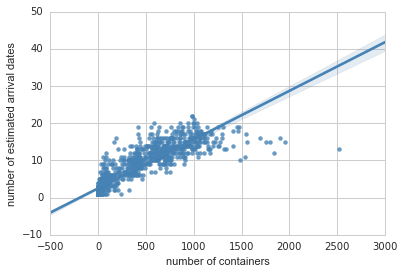

In [16]:
#show the relationship between volume and the number of estimated arrival dates with a scatter plot
ax = sns.regplot(x="container_number", y="estimated_arrival_date", data=voyage_stats_all, color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('number of containers')
ax.set_ylabel('number of estimated arrival dates')

** Consolidate observations by identifier ** 

description text won't be analyzed for this as the added complexity is beyond the scope of this analysis

In [65]:
#add a combined shipper - consigner column in case the combinations of these makes a difference
df['shipper_consigner'] = df.shipper_party_name.str.cat(df.consignee_name.astype(str), sep='-')

In [66]:
list(df)

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name_orig',
 'port_of_unlading',
 'estimated_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'port_of_destination',
 'foreign_port_of_destination',
 'actual_arrival_date',
 'consignee_name',
 'shipper_party_name',
 'container_number',
 'description_sequence_number',
 'piece_count',
 'description_text',
 'carrier',
 'day_of_week_est',
 'day_of_week_act',
 'month_est',
 'month_act',
 'delay_days',
 'vessel_name',
 'shipper_consigner']

In [83]:
#check that there is a piece count for all observations
len(df),len(df.piece_count >= 1)

(658583, 658583)

In [73]:
#description sequence number shows order of shipments for the same consigner-shipper pair
df[df.identifier == 2014102195].iloc[:,0:17]

,identifier,trade_update_date,run_date,vessel_name_orig,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,foreign_port_of_destination,actual_arrival_date,consignee_name,shipper_party_name,container_number,description_sequence_number,piece_count
9052012,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,1,3
9052013,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,2,2
9052014,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,3,3
9052015,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,4,2
9052016,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,5,3
9052017,2014102195,2014-04-22,2014-10-21,CSCL WINTER,"Los Angeles, California",2014-05-10,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-05-12,GENESCO INC,CHANGSHU ARTISAN LEATHER GOODS,CCLU4569975,6,2


In [241]:
#set up the groupby and count fields
df_count = df[['identifier','trade_update_date','run_date','vessel_name_orig','vessel_name','carrier',
          'port_of_unlading','estimated_arrival_date','actual_arrival_date','foreign_port_of_lading',
          'record_status_indicator','place_of_receipt','day_of_week_est','day_of_week_act','month_est',
          'month_act','delay_days','consignee_name','shipper_party_name','shipper_consigner','container_number']]

df_sum = df[['identifier','trade_update_date','run_date','vessel_name_orig','vessel_name','carrier',
          'port_of_unlading','estimated_arrival_date','actual_arrival_date','foreign_port_of_lading',
          'record_status_indicator','place_of_receipt','day_of_week_est','day_of_week_act','month_est',
          'month_act','delay_days','piece_count']]

id_groupby_fields = ['identifier','trade_update_date','run_date','vessel_name_orig','vessel_name','carrier',
                     'port_of_unlading','estimated_arrival_date','actual_arrival_date','foreign_port_of_lading',
                     'record_status_indicator','place_of_receipt','day_of_week_est','day_of_week_act','month_est',
                     'month_act','delay_days']

In [242]:
#Get the unique count
df2 = df_count.groupby(id_groupby_fields,as_index=False).agg(['nunique'])

In [243]:
#get the sum of the piece count as well as number of shipments
df2_sum = df_sum.groupby(id_groupby_fields,as_index=False).agg(['sum','count'])

In [244]:
#reformat columns
df2.columns = ['_'.join(tup).rstrip('_') for tup in df2.columns.values]
df2.reset_index(col_level=1,inplace = True)

df2_sum.columns = ['_'.join(tup).rstrip('_') for tup in df2_sum.columns.values]
df2_sum.reset_index(col_level=1,inplace = True)


In [245]:
df2

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,actual_arrival_date,foreign_port_of_lading,...,place_of_receipt,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,2014-02-06,"Shanghai ,China (Mainland)",...,SHANGHAI,2,3,2,2,1,0,0,0,1
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",...,SHANGHAI,1,5,2,2,4,1,1,1,1
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",...,SHANGHAI,1,5,2,2,4,0,0,0,1
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,2014-05-25,"Shanghai ,China (Mainland)",...,SHANGHAI,6,6,5,5,0,1,1,1,1
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,2014-05-15,"Shanghai ,China (Mainland)",...,"JIANGYIN, CHINA",3,3,5,5,7,1,1,1,14
5,201412313,2014-01-06,2014-12-31,BALTIMORE BRIDGE,BALTIMORE BRIDGE,BALTIMORE,"Long Beach, California",2014-01-22,2014-01-27,"Shanghai ,China (Mainland)",...,SHANGHAI,2,0,1,1,5,1,1,1,1
6,201412314,2014-01-09,2014-12-31,BALTIMORE BRIDGE,BALTIMORE BRIDGE,BALTIMORE,"Long Beach, California",2014-01-22,2014-01-27,"Shanghai ,China (Mainland)",...,SHANGHAI,2,0,1,1,5,1,1,1,2
7,201412316,2014-12-30,2014-12-31,BALTIMORE BRIDGE,BALTIMORE BRIDGE,BALTIMORE,"Long Beach, California",2014-01-22,2014-01-27,"Shanghai ,China (Mainland)",...,SHANGHAI,2,0,1,1,5,1,1,1,1
8,201412317,2014-01-06,2014-12-31,BALTIMORE BRIDGE,BALTIMORE BRIDGE,BALTIMORE,"Long Beach, California",2014-01-22,2014-01-27,"Shanghai ,China (Mainland)",...,SHANGHAI,2,0,1,1,5,1,1,1,2
9,2014031028,2014-02-20,2014-03-10,XIN YA ZHOU,XIN YA ZHOU,XIN,"Los Angeles, California",2014-03-08,2014-03-09,"Shanghai ,China (Mainland)",...,TAICANG,5,6,3,3,1,1,1,1,2


In [246]:
df2_sum

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,actual_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,piece_count_sum,piece_count_count
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,2014-02-06,"Shanghai ,China (Mainland)",Amended,SHANGHAI,2,3,2,2,1,126,1
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",Amended,SHANGHAI,1,5,2,2,4,1000,1
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",Amended,SHANGHAI,1,5,2,2,4,2079,1
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,2014-05-25,"Shanghai ,China (Mainland)",Amended,SHANGHAI,6,6,5,5,0,14,1
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,2014-05-15,"Shanghai ,China (Mainland)",Amended,"JIANGYIN, CHINA",3,3,5,5,7,196,14
5,201412313,2014-01-06,2014-12-31,BALTIMORE BRIDGE,BALTIMORE BRIDGE,BALTIMORE,"Long Beach, California",2014-01-22,2014-01-27,"Shanghai ,China (Mainland)",Amended,SHANGHAI,2,0,1,1,5,80,1
6,201412314,2014-01-09,2014-12-31,BALTIMORE BRIDGE,BALTIMORE BRIDGE,BALTIMORE,"Long Beach, California",2014-01-22,2014-01-27,"Shanghai ,China (Mainland)",Amended,SHANGHAI,2,0,1,1,5,43,2
7,201412316,2014-12-30,2014-12-31,BALTIMORE BRIDGE,BALTIMORE BRIDGE,BALTIMORE,"Long Beach, California",2014-01-22,2014-01-27,"Shanghai ,China (Mainland)",Amended,SHANGHAI,2,0,1,1,5,22,1
8,201412317,2014-01-06,2014-12-31,BALTIMORE BRIDGE,BALTIMORE BRIDGE,BALTIMORE,"Long Beach, California",2014-01-22,2014-01-27,"Shanghai ,China (Mainland)",Amended,SHANGHAI,2,0,1,1,5,890,2
9,2014031028,2014-02-20,2014-03-10,XIN YA ZHOU,XIN YA ZHOU,XIN,"Los Angeles, California",2014-03-08,2014-03-09,"Shanghai ,China (Mainland)",New,TAICANG,5,6,3,3,1,1125,2


In [247]:
#change the column header for piece_count_count to shipment_count
df2_sum=df2_sum.rename(columns = {'piece_count_count':'shipment_count'})

In [248]:
#merge the sum into df2
df2 = df2.merge(df2_sum, on = id_groupby_fields, how = 'left')

In [249]:
#compare groupby dataframe to original
df2.shape, df.shape

((374871, 23), (658583, 26))

In [250]:
df2.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,actual_arrival_date,foreign_port_of_lading,...,day_of_week_act,month_est,month_act,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,2014-02-06,"Shanghai ,China (Mainland)",...,3,2,2,1,0,0,0,1,126,1
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",...,5,2,2,4,1,1,1,1,1000,1
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",...,5,2,2,4,0,0,0,1,2079,1
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,2014-05-25,"Shanghai ,China (Mainland)",...,6,5,5,0,1,1,1,1,14,1
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,2014-05-15,"Shanghai ,China (Mainland)",...,3,5,5,7,1,1,1,14,196,14


** Review the delay days distribution **

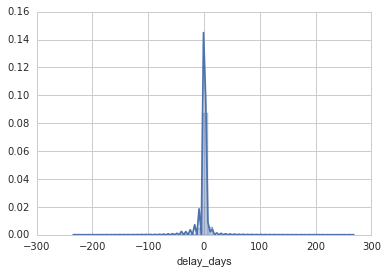

In [251]:
sns.distplot(df2.delay_days)

In [252]:
#get statistics on delay days
df2.delay_days.describe()

count    374871.000000
mean          0.663415
std           6.225818
min        -234.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         268.000000
Name: delay_days, dtype: float64

In [253]:
#Look at extreme values - less than 1%
df2.delay_days.quantile(0.01), df2.delay_days.quantile(0.99)

(-26.0, 14.0)

In [254]:
#view outliers
df2_outs = df2[(df2.delay_days < -30) | (df2.delay_days > 30)].sort_values('delay_days')

In [255]:
df2_outs.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,actual_arrival_date,foreign_port_of_lading,...,day_of_week_act,month_est,month_act,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count
32430,2014011136313,2013-12-24,2014-01-11,SUN ROAD,SUN ROAD,SUN,"Long Beach, California",2014-09-01,2014-01-10,"Shanghai ,China (Mainland)",...,4,9,1,-234,0,0,0,1,380,1
374804,20140812164017,2014-08-07,2014-08-12,CSCL AUTUMN,CSCL AUTUMN,CSCL,"Los Angeles, California",2014-08-23,2014-02-10,"Shanghai ,China (Mainland)",...,0,8,2,-194,1,1,1,1,1148,1
374803,20140812164015,2014-08-07,2014-08-12,CSCL AUTUMN,CSCL AUTUMN,CSCL,"Los Angeles, California",2014-08-23,2014-02-10,"Shanghai ,China (Mainland)",...,0,8,2,-194,1,1,1,1,680,1
238049,2014080941007,2014-08-07,2014-08-09,CSCL AUTUMN,CSCL AUTUMN,CSCL,"Los Angeles, California",2014-08-23,2014-02-10,"Shanghai ,China (Mainland)",...,0,8,2,-194,1,1,1,1,1148,1
238048,2014080941006,2014-08-07,2014-08-09,CSCL AUTUMN,CSCL AUTUMN,CSCL,"Los Angeles, California",2014-08-23,2014-02-10,"Shanghai ,China (Mainland)",...,0,8,2,-194,1,1,1,1,680,1


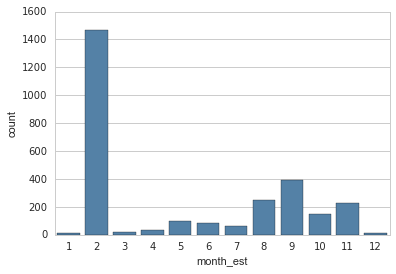

In [256]:
#get the number of outliers by month to see if there are patterns
sns.countplot(x="month_est", data=df2_outs, color = 'steelblue');

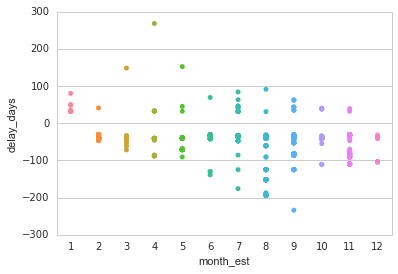

In [257]:
#view outlier scatter by month
sns.stripplot(x="month_est", y="delay_days", data=df2_outs)

In [258]:
#number of carriers that are part of the outliers
len(df2.carrier.unique()), len(df2_outs.carrier.unique())

(141, 32)

In [259]:
print df2.shape, df2_outs.shape
print round(len(df2_outs)/(len(df2)*1.0),4)

(374871, 23) (2809, 23)
0.0075


Less than 1% of identifiers have actual arrival dates that are more than +/- 30 days from the estimated arrival dates so these will be removed from the analysis.
Differences between the expected arrival date and actual arrival date of over 30 days may be extreme events or data errors

** Create a new dataframe that removes observations where the actual arrival date is more than +/- 30 days from the estimated arrival date **

In [266]:
df3 = df2[(df2.delay_days >= -30) & (df2.delay_days <= 30)]

In [267]:
df3.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,actual_arrival_date,foreign_port_of_lading,...,day_of_week_act,month_est,month_act,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,2014-02-06,"Shanghai ,China (Mainland)",...,3,2,2,1,0,0,0,1,126,1
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",...,5,2,2,4,1,1,1,1,1000,1
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",...,5,2,2,4,0,0,0,1,2079,1
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,2014-05-25,"Shanghai ,China (Mainland)",...,6,5,5,0,1,1,1,1,14,1
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,2014-05-15,"Shanghai ,China (Mainland)",...,3,5,5,7,1,1,1,14,196,14


In [268]:
df3.shape

(372062, 23)

** Review identifiers with no shipper or no consigner information vs those that do have information  ** 

In [269]:
#Look at identifiers with no shipper or consigner names
print len(df3[(df3.consignee_name_nunique == 0) | (df3.shipper_party_name_nunique == 0)]) 
print round(len(df3[(df3.consignee_name_nunique == 0) | (df3.shipper_party_name_nunique == 0)])/ (len(df3) * 1.0),4)

69088
0.1857


18% of observations have no consignee or shipper, this is too large a percentage to drop

In [270]:
#identifiers with no shipper or consigner
df3[(df3.consignee_name_nunique == 0) | (df3.shipper_party_name_nunique == 0)].identifier.head()

0      201406038
2      201406059
10    2014032679
11    2014032689
12    2014032885
Name: identifier, dtype: uint64

In [271]:
df[df.identifier == 201406038].iloc[:,0:17]

,identifier,trade_update_date,run_date,vessel_name_orig,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,foreign_port_of_destination,actual_arrival_date,consignee_name,shipper_party_name,container_number,description_sequence_number,piece_count
9763475,201406038,2014-01-16,2014-06-03,HANJIN KOREA,"Long Beach, California",2014-02-05,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,NaN,2014-02-06,NaN,NaN,HJCU4123330,1,126


In [278]:
#add a no_shipper_info column with a 1 if there is no shipper or consigner column, 0 otherwise
df3['no_ship_consign'] = np.where((df3.consignee_name_nunique == 0) | (df3.shipper_party_name_nunique == 0),1,0)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


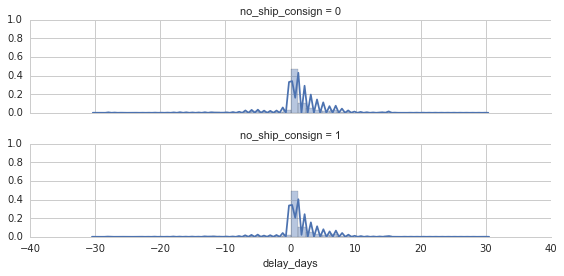

In [300]:
#view distributions of delays days
g = sns.FacetGrid(df3, row="no_ship_consign",size=2, aspect=4)
g.map(sns.distplot, "delay_days")
g.set(ylim=(0, 1))

The distributions look very similar, column will be maintained as a feature

** Set up the initial features and look for correlations **

In [301]:
list(df3)

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name_orig',
 'vessel_name',
 'carrier',
 'port_of_unlading',
 'estimated_arrival_date',
 'actual_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'day_of_week_est',
 'day_of_week_act',
 'month_est',
 'month_act',
 'delay_days',
 'consignee_name_nunique',
 'shipper_party_name_nunique',
 'shipper_consigner_nunique',
 'container_number_nunique',
 'piece_count_sum',
 'shipment_count',
 'no_ship_consign']

Determine if either of the following can be turned into features:
- place_of_receipt: evaluate number of different places, can they be categorized by volume?
- carrier: top 5/top 10 by volume (binary variable)

In [305]:
#number of unique places_of_receipt
len(df3.place_of_receipt.unique())

880

In [306]:
#view the list
list(df3.place_of_receipt.unique())

['SHANGHAI',
 'JIANGYIN, CHINA',
 'TAICANG',
 'SHANGHAI, PC',
 'SHANGHAI, CHINA',
 'MUMBAI',
 'HANGZHOU CN',
 'SHANGHAI CN',
 'CHONGQING',
 'SHANGHAI,SH,CN',
 'JIUJIANG',
 'NANJING',
 'SHANGHAI,CHINA,CF',
 'SHANGHAI,CFS',
 'CHANGSHA,DOOR',
 'WUJIANG',
 'ZHANGJIAGANG',
 'NANTONG',
 'YANGZHOU',
 'YANGSHAN, PC',
 'QINGDAO',
 'ANQING',
 'WUHAN, CHINA',
 'ZHANGJIAGANG, CHI',
 'CHANGZHOU',
 'WUHAN',
 'CHONG QING,CHI',
 'CHENNAI (EX MADRA',
 'ICD,DADRI',
 'MUNDRA, INDIA',
 'TUTICORIN, INDIA',
 'NHAVA SHEVA',
 'MANILA, PHILS',
 'WUXI',
 'NINGBO',
 'SUZHOU',
 'NANCHANG',
 'SHANGHAI,CN',
 'HANGZHOU',
 'CNSHA',
 'LIANYUNGANG,CN',
 'ALL OTH PEOPLES R',
 'TAIZHOU CITY CN',
 'WUXI CN',
 'NHAVA SHEVA, INDI',
 'PENANG',
 'MUNDRA',
 'KARACHI',
 'ANKLESHWAR, INDIA',
 'BDCGP',
 'KARACHI, PAKISTAN',
 'DALIAN',
 'WUHAN,HUBEI',
 'DURBAN, ZA',
 'NHAVA SHEVA INDIA',
 'MANILA',
 'SHANGHAI,CHINA',
 'WUHU, CHINA',
 'SHANGHAI.CHINA.',
 'TIANJIN,TJCN',
 'CHENGDU',
 'PUDONG, SHANGHAI',
 'WUHAN, CN',
 'YICHANG, CHIN

The place of receipt list does not have standardized names, and it would be time consuming to use text analysis to standardize, so this will not be used as a feature

In [307]:
#view unique list of carriers.
#Note: the carrier was created from the first word of the ship name which is not always the carrier name
len(df3.carrier.unique())

141

In [308]:
list(df3.carrier.unique())

['HANJIN',
 'CMACGM',
 'CSCL',
 'BALTIMORE',
 'XIN',
 'NYK',
 'APL',
 'MOL',
 'R',
 'KOTA',
 'OOCL',
 'MSC',
 'BAI',
 'COSCO',
 'MANULANI',
 'EVER',
 'CMA',
 'HATSU',
 'BAY',
 'BANGKOK',
 'HYUNDAI',
 'BROOKLYN',
 'MAUNAWILI',
 'PACIFIC',
 'STADT',
 'BRUSSELS',
 'HANSA',
 'DUESSELDORF',
 'MALIAKOS',
 'HS',
 'YM',
 'NAVARINO',
 'HAMMONIA',
 'AUGUSTA',
 'ANTON',
 'SEROJA',
 'KOBE',
 'AAL',
 'SUN',
 'OAKLAND',
 'UASC',
 'BEAR',
 'MANUKAI',
 'CAM',
 'LONDON',
 'HALIFAX',
 'ZHEN',
 'SINGAPORE',
 'TOKYO',
 'SEOUL',
 'HOECHST',
 'SCL',
 'MONTE',
 'DALLAS',
 'CHARLES',
 'DRESDEN',
 'STUTTGART',
 'TAMESIS',
 'STAR',
 'MATSONIA',
 'MAUNALEI',
 'BOSTON',
 'BAICHAY',
 'ARNOLD',
 'OSAKA',
 'JINHE',
 'ALBERT',
 'CSAV',
 'CHARLOTTE',
 'DS',
 'RJ',
 'ATLANTIC',
 'PACIFC',
 'SL',
 'VICTORIA',
 'PARIS',
 'AMBASSADOR',
 'HYUNDAITOKYO',
 'HANOVER',
 'LUHE',
 'BALTIMORE?BRIDGE',
 'KYOTO',
 'ADRIAN',
 'R.J.',
 'R.',
 '9337937',
 'HONGWANGJI',
 'MA',
 'ITAL',
 'SEA-LAND',
 'WLADYSLAW',
 'ATLANTA',
 '9630365',

In [314]:
df3.container_number_nunique.sum()

558294L

In [321]:
#get top 10 by volume
carrier_by_volume = df3[['carrier','container_number_nunique']].groupby(
    'carrier',as_index = False).sum().sort_values(
    'container_number_nunique',ascending = False)

In [329]:
sum(df3.container_number_nunique)

558294

In [331]:
carrier_by_volume.head(5)

,carrier,container_number_nunique
1554,HANJIN,105424.0
2397,MSC,57362.0
982,CSCL,53954.0
888,CMA,36168.0
395,APL,32906.0


In [333]:
carrier_by_volume.container_number_nunique.head(5).sum()

285814.0

In [336]:
top_5_list = list(carrier_by_volume.head(5).carrier)
top_5_list

['HANJIN', 'MSC', 'CSCL', 'CMA', 'APL']

The top 5 carriers represent over 50% of the container volume, set up a variable for top 5  
*Note possible name misspellings will be ignored*

In [337]:
df3['top5_carrier'] = np.where(df3.carrier.isin(top_5_list),1,0)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [341]:
list(df3)

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name_orig',
 'vessel_name',
 'carrier',
 'port_of_unlading',
 'estimated_arrival_date',
 'actual_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'day_of_week_est',
 'day_of_week_act',
 'month_est',
 'month_act',
 'delay_days',
 'consignee_name_nunique',
 'shipper_party_name_nunique',
 'shipper_consigner_nunique',
 'container_number_nunique',
 'piece_count_sum',
 'shipment_count',
 'no_ship_consign',
 'top5_carrier']

Set up features

In [345]:
df_features = df3[['delay_days','record_status_indicator','day_of_week_est','month_est','consignee_name_nunique',
                   'shipper_party_name_nunique','shipper_consigner_nunique','container_number_nunique',
                   'piece_count_sum','shipment_count','no_ship_consign','top5_carrier']]

In [346]:
#one hot encode variables
df_features = pd.get_dummies(df_features,columns=['record_status_indicator',
                                                 'month_est',
                                                 'day_of_week_est'])

In [347]:
#drop record status deleted (records with a deleted status were dropped earlier in the analysis)
df_features.drop('record_status_indicator_Deleted',1,inplace = True)

In [348]:
list(df_features)

['delay_days',
 'consignee_name_nunique',
 'shipper_party_name_nunique',
 'shipper_consigner_nunique',
 'container_number_nunique',
 'piece_count_sum',
 'shipment_count',
 'no_ship_consign',
 'top5_carrier',
 'record_status_indicator_Amended',
 'record_status_indicator_New',
 'month_est_1',
 'month_est_2',
 'month_est_3',
 'month_est_4',
 'month_est_5',
 'month_est_6',
 'month_est_7',
 'month_est_8',
 'month_est_9',
 'month_est_10',
 'month_est_11',
 'month_est_12',
 'day_of_week_est_0',
 'day_of_week_est_1',
 'day_of_week_est_2',
 'day_of_week_est_3',
 'day_of_week_est_4',
 'day_of_week_est_5',
 'day_of_week_est_6']

In [349]:
df_features.head()

,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count,no_ship_consign,top5_carrier,record_status_indicator_Amended,...,month_est_10,month_est_11,month_est_12,day_of_week_est_0,day_of_week_est_1,day_of_week_est_2,day_of_week_est_3,day_of_week_est_4,day_of_week_est_5,day_of_week_est_6
0,1,0,0,0,1,126,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1,4,1,1,1,1,1000,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,4,0,0,0,1,2079,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,0,1,1,1,1,14,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,7,1,1,1,14,196,14,0,1,1,...,0,0,0,0,0,0,1,0,0,0


In [350]:
#create a pairwise correlation matrix
df_corr = df_features.corr()

In [351]:
df_corr

,delay_days,consignee_name_nunique,shipper_party_name_nunique,shipper_consigner_nunique,container_number_nunique,piece_count_sum,shipment_count,no_ship_consign,top5_carrier,record_status_indicator_Amended,...,month_est_10,month_est_11,month_est_12,day_of_week_est_0,day_of_week_est_1,day_of_week_est_2,day_of_week_est_3,day_of_week_est_4,day_of_week_est_5,day_of_week_est_6
delay_days,1.000000,-0.010433,-0.011262,-0.014256,0.012479,0.005161,0.004825,0.008071,0.111853,-0.129789,...,0.082864,0.263910,0.082252,0.014528,-0.001598,0.025537,-0.052016,0.025893,0.010930,-0.027521
consignee_name_nunique,-0.010433,1.000000,0.961023,0.887030,0.029115,0.035695,0.113628,-0.918238,-0.023938,0.024302,...,-0.021201,-0.004673,0.003004,-0.038988,0.020549,-0.004858,-0.025507,-0.008783,0.012516,0.045898
shipper_party_name_nunique,-0.011262,0.961023,1.000000,0.913086,0.023966,0.033704,0.107563,-0.959867,-0.021072,0.030048,...,-0.021086,-0.003013,0.001472,-0.043106,0.022060,-0.002572,-0.029027,-0.007307,0.014758,0.046152
shipper_consigner_nunique,-0.014256,0.887030,0.913086,1.000000,0.058431,0.071632,0.226732,-0.763263,-0.018160,0.039898,...,-0.032190,-0.018119,-0.011877,-0.025781,0.009632,-0.016834,-0.034647,-0.002244,0.015804,0.053841
container_number_nunique,0.012479,0.029115,0.023966,0.058431,1.000000,0.110476,0.562538,0.001360,0.018235,-0.022353,...,-0.007673,-0.005197,-0.002352,0.009708,0.016104,-0.014724,-0.005657,-0.002325,0.003571,-0.002196
piece_count_sum,0.005161,0.035695,0.033704,0.071632,0.110476,1.000000,0.144143,-0.004599,-0.007912,-0.009072,...,-0.008162,-0.007542,-0.003526,0.001348,-0.000499,0.000131,-0.005373,-0.005627,-0.000074,0.008820
shipment_count,0.004825,0.113628,0.107563,0.226732,0.562538,0.144143,1.000000,-0.016403,0.011330,0.008818,...,-0.014871,-0.014827,-0.011894,0.012501,0.008082,-0.016366,-0.012327,0.003045,0.005322,0.002559
no_ship_consign,0.008071,-0.918238,-0.959867,-0.763263,0.001360,-0.004599,-0.016403,1.000000,0.020911,-0.020506,...,0.011435,-0.007533,-0.010427,0.050428,-0.028386,-0.007344,0.022410,0.010068,-0.012505,-0.036328
top5_carrier,0.111853,-0.023938,-0.021072,-0.018160,0.018235,-0.007912,0.011330,0.020911,1.000000,0.078667,...,-0.004325,0.015748,-0.031623,-0.115141,0.133915,0.077808,-0.112112,0.050381,0.036156,-0.059135
record_status_indicator_Amended,-0.129789,0.024302,0.030048,0.039898,-0.022353,-0.009072,0.008818,-0.020506,0.078667,1.000000,...,0.041653,0.014436,-0.061885,-0.098021,0.018806,0.065674,-0.021660,0.071632,0.010145,-0.048054


In [352]:
df_corr[['delay_days']]

,delay_days
delay_days,1.000000
consignee_name_nunique,-0.010433
shipper_party_name_nunique,-0.011262
shipper_consigner_nunique,-0.014256
container_number_nunique,0.012479
piece_count_sum,0.005161
shipment_count,0.004825
no_ship_consign,0.008071
top5_carrier,0.111853
record_status_indicator_Amended,-0.129789


** Additional features to consider if more features are needed **

month of run_date  
month of trade_update_date  

** Output files **

In [355]:
#convert df3 to a file
df3.to_pickle('D:/CUNY Files/capstone/code files/2014_LA_SH_Summary.pkl')

In [356]:
#convert df_features to a file
df_features.to_pickle('D:/CUNY Files/capstone/code files/2014_features.pkl')